In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import scipy.signal as sig

In [ ]:
## For this analysis, I chose to investigate into the correlations between XOM (ExxonMobil, 
## the largest Oil & Gas Company in the US) and Crude oil as well as other engergy commodities.

## Data source:
## stock: https://www.kaggle.com/camnugent/sandp500
## commodity: https://www.kaggle.com/mattiuzc/commodity-futures-price-history

In [ ]:
## Data Preparation

In [2]:
commodity_src = 'Commodity data/'
stock_src = 'archive/individual_stocks_5yr/individual_stocks_5yr/'

In [3]:
brent = pd.read_csv(commodity_src + 'Brent Crude Oil.csv')
XOM = pd.read_csv(stock_src + 'XOM_data.csv')
crude = pd.read_csv(commodity_src + 'Crude Oil.csv')
ng = pd.read_csv(commodity_src + 'Natural Gas.csv')
ho = pd.read_csv(commodity_src + 'Heating Oil.csv')
gas = pd.read_csv(commodity_src + 'RBOB Gasoline.csv')

In [5]:
XOM = XOM.rename(columns={'date' : 'Date', 'open' : 'Open', 'high' : 'High', 'low' : 'Low', 'close' : 'Close'})

In [ ]:
## Find the common time period among all tickers we are going to investigate

In [6]:
def find_common_period(tickers):
    ## Find the common time range for all input tickers and return 
    ## The dataframes with the same time range as a list in the input order
    ## Raise Exception if input contains non-timeseries dataframe
    
    ## Input: [dataframes]
    ## Output: [dataframes]
    
    start_dates = []
    end_dates = []
    for ticker in tickers:
        if ('date' in ticker):
            start_dates.append(min(ticker['date']))
            end_dates.append(max(ticker['date']))
        elif ('Date' in ticker):
            start_dates.append(min(ticker['Date']))
            end_dates.append(max(ticker['Date']))
        else:
            raise Exception('No time found in seires')
    start_date = max(start_dates)
    end_date = min(end_dates)
    filtered = []
    for ticker in tickers:
        if ('date' in ticker):
            cond1 = ticker['date'] >= start_date
            cond2 = ticker['date'] <= end_date
            filtered.append(ticker[cond1 & cond2])
        elif ('Date' in ticker):
            cond1 = ticker['Date'] >= start_date
            cond2 = ticker['Date'] <= end_date
            filtered.append(ticker[cond1 & cond2])
        else:
            raise Exception('No time found in seires')
    return filtered

In [7]:
[xom_filtered, brent_filtered, crude_filtered, ng_filtered, ho_filtered, gas_filtered] = find_common_period([XOM, brent, crude, ng, ho, gas])

In [ ]:
## Plot the close price of each ticker

<AxesSubplot:xlabel='Date'>

<Figure size 432x288 with 0 Axes>

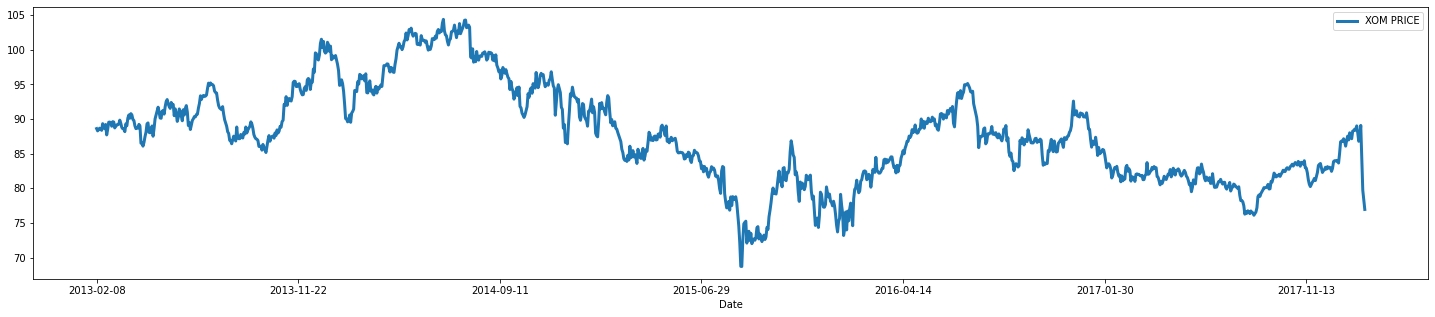

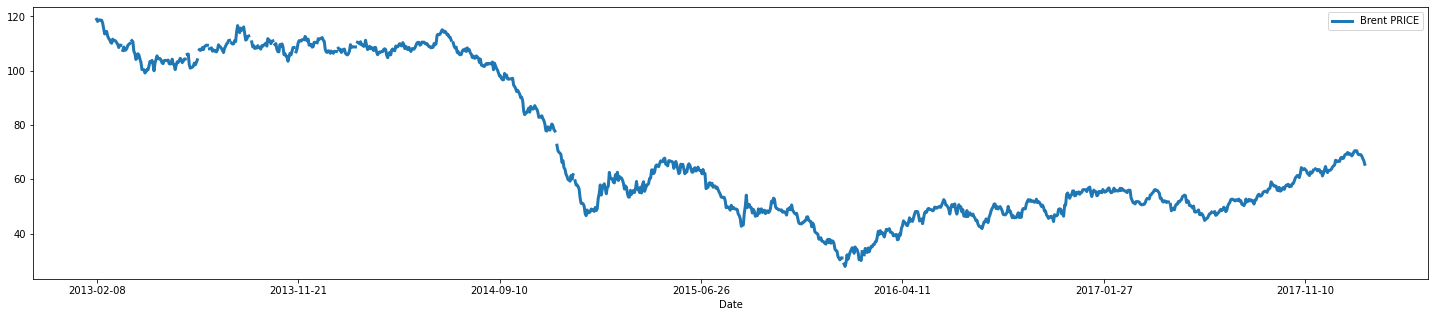

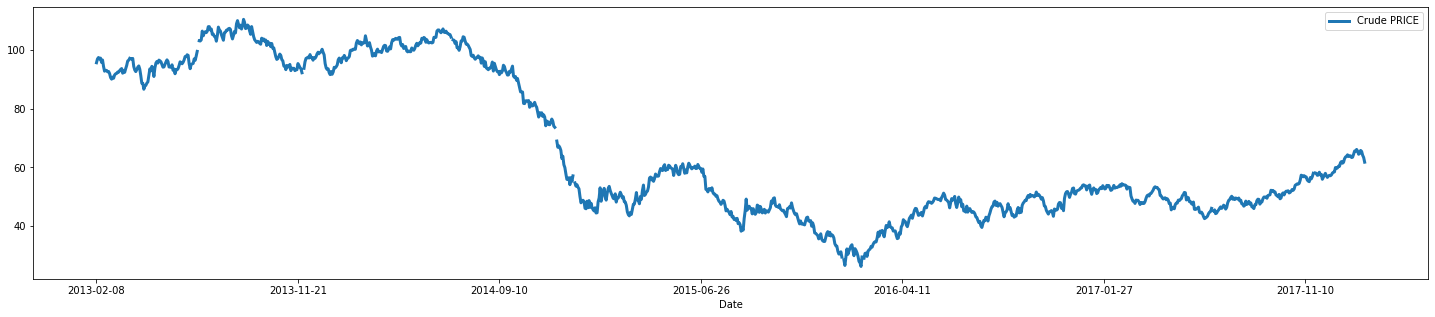

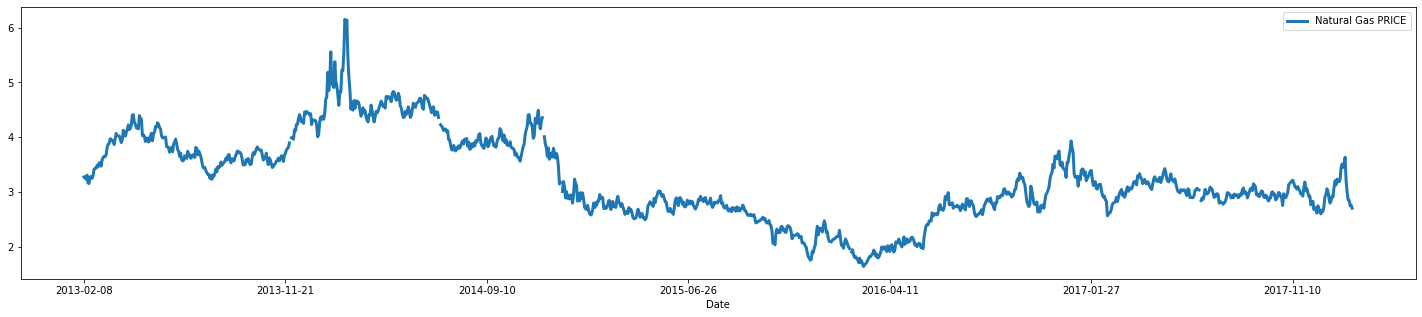

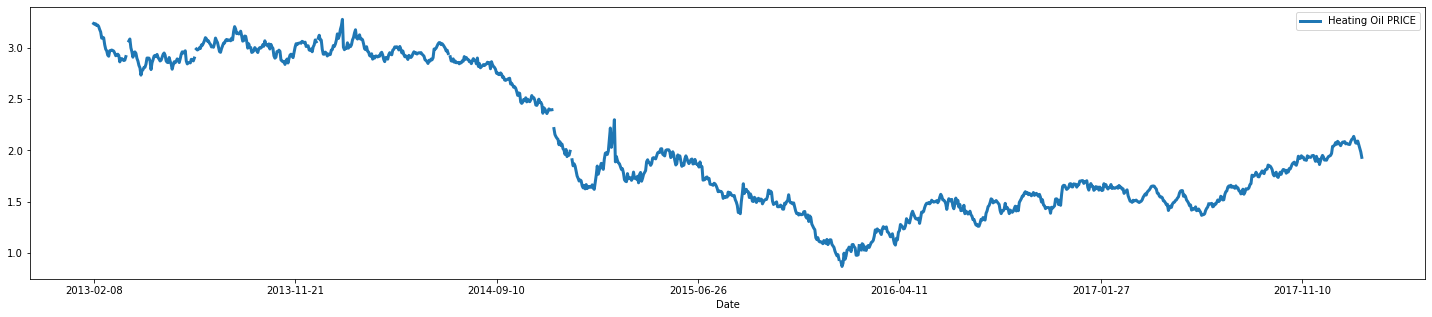

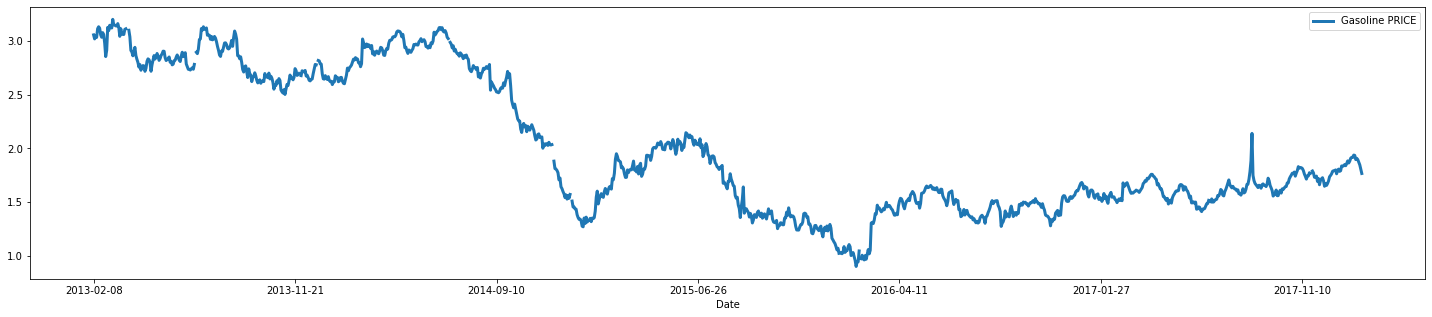

In [8]:
fig = plt.figure()

xom_filtered.plot(x='Date', y='Close', figsize=[25,5], label='XOM PRICE', lw = 3)
plt.legend(loc = 1,fontsize=10)
brent_filtered.plot(x='Date', y='Close', figsize=[25,5], label='Brent PRICE', lw = 3)
crude_filtered.plot(x='Date', y='Close', figsize=[25,5], label='Crude PRICE', lw = 3)
ng_filtered.plot(x='Date', y='Close', figsize=[25,5], label='Natural Gas PRICE', lw = 3)
ho_filtered.plot(x='Date', y='Close', figsize=[25,5], label='Heating Oil PRICE', lw = 3)
gas_filtered.plot(x='Date', y='Close', figsize=[25,5], label='Gasoline PRICE', lw = 3)

In [9]:
## First approach: Use linear algebra and the provided APIs to find the correlations between each pair of tickers

In [ ]:
## Prepare the close price series for correlation calculation

In [10]:
XOM_CLOSE = (xom_filtered[['Date','Close']]).reset_index(drop=True)
XOM_CLOSE.columns = ['Date', 'XOM_Close']

BRENT_CLOSE = (brent_filtered[['Date', 'Close']]).reset_index(drop=True)
BRENT_CLOSE.columns = ['Date', 'BRENT_Close']

CRUDE_CLOSE = (crude_filtered[['Date', 'Close']]).reset_index(drop=True)
CRUDE_CLOSE.columns = ['Date', 'CRUDE_Close']

NG_CLOSE = (ng_filtered[['Date', 'Close']]).reset_index(drop=True)
NG_CLOSE.columns = ['Date', 'NG_Close']

HO_CLOSE = (ho_filtered[['Date', 'Close']]).reset_index(drop=True)
HO_CLOSE.columns = ['date', 'HO_Close']

GAS_CLOSE = (gas_filtered[['Date', 'Close']]).reset_index(drop=True)
GAS_CLOSE.columns = ['Date', 'GAS_Close']

In [ ]:
## Prepare the full datatable for other use

In [11]:
XOM = (xom_filtered[['Date', 'Open', 'Close', 'High', 'Low']]).reset_index(drop=True)
XOM.columns = ['Date', 'XOM_Open', 'XOM_Close', 'XOM_High', 'XOM_Low']

BRENT = (brent_filtered[['Date', 'Open', 'Close', 'High', 'Low']]).reset_index(drop=True)
BRENT.columns = ['Date', 'BRENT_Open', 'BRENT_Close', 'BRENT_High', 'BRENT_Low']

CRUDE = (crude_filtered[['Date', 'Open', 'Close', 'High', 'Low']]).reset_index(drop=True)
CRUDE.columns = ['Date', 'CRUDE_Open', 'CRUDE_Close', 'CRUDE_High', 'CRUDE_Low']

NG = (ng_filtered[['Date', 'Open', 'Close', 'High', 'Low']]).reset_index(drop=True)
NG.columns = ['Date', 'NG_Open', 'NG_Close', 'NG_High', 'NG_Low']

HO = (ho_filtered[['Date', 'Open', 'Close', 'High', 'Low']]).reset_index(drop=True)
HO.columns = ['date', 'HO_Open', 'HO_Close', 'HO_High', 'HO_Low']

GAS = (gas_filtered[['Date', 'Open', 'Close', 'High', 'Low']]).reset_index(drop=True)
GAS.columns = ['Date', 'GAS_Open', 'GAS_Close', 'GAS_High', 'Gas_Low']

In [ ]:
## Combine the close prices into a datatable, calculate and plot the correlations

In [12]:
total_close = pd.concat([XOM_CLOSE, BRENT_CLOSE, CRUDE_CLOSE, NG_CLOSE, HO_CLOSE, GAS_CLOSE], axis=1)

In [13]:
total_close = total_close.loc[ :, ~total_close.columns.duplicated()]
total_close = total_close.dropna()

/var/folders/2c/s0cz85mn0s7cq00wht2k3_hh0000gn/T/ipykernel_49946/3972739515.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(total_close.corr(), dtype=np.bool))


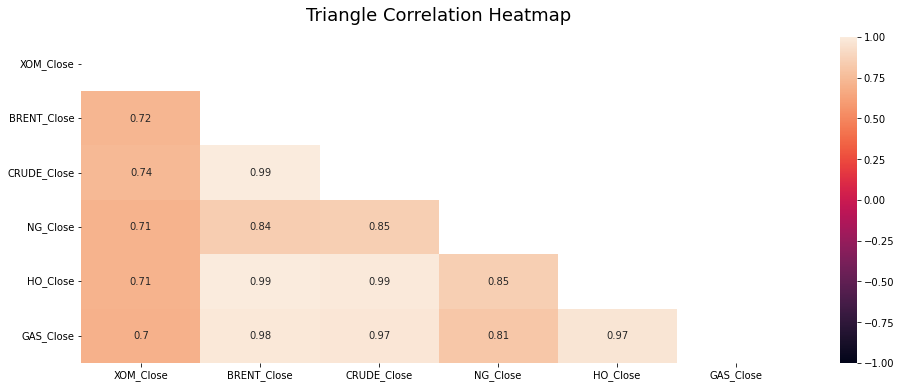

In [14]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(total_close.corr(), dtype=np.bool))
heatmap = sns.heatmap(total_close.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [ ]:
## Comments: 
## 1. as we can see from the correlation heapmap above, the prices between crude oil and gas are highly 
## correlated, which meets our original expectation. The stock price of XOM are also correlated to the energy 
## commodity prices. 

## 2. however, the analysis above is far away fram guiding real investments. 

In [ ]:
## Combine the full datatables into a larger datatable for other use

In [15]:
total = pd.concat([XOM, BRENT, CRUDE, NG, HO, GAS], axis=1)
total = total.loc[ :, ~total.columns.duplicated()]
total = total.dropna()

In [16]:
## Second approach: using LSTM to predict the stock price. 
## Input channels: prices of Crude Oil, Natural Gas, Gasoline
## Output channel: the price of XOM

## General idea: LSTM has been proved to be good at processing timeseries data and discovering the hidden patterns.
## If the prices are correlated, we might be able to construct a LSTM network to find the correlations between the 
## stock price of XOM and energy commodities. 
## Use the commodity prices within last X days as input, the predicted stock price of XOM as output.

In [17]:
## Preparation: data normalisation

class normaliser:
    def __init__(self):
        self.mu = None
        self.std = None
    
    def fit(self, data):
        self.mu = np.mean(data, axis=0, keepdims=True)
        self.std = np.std(data, axis=0, keepdims=True)
        norm = (data - self.mu) / self.std
        return norm
    
    def inv(self, data):
        return (data * self.std) + self.mu

In [18]:
## Preparation: transfer the time series into data matrix of shape: (number of windows, window length)

def windowing_x(data, window):
    rows = np.shape(data)[0] - window + 1
    matrix = np.lib.stride_tricks.as_strided(data, shape=(rows, window), strides=(data.strides[0], data.strides[0]))
    return matrix[ : -1]

def windowing_y(data, window):
    return data[window : ]

In [19]:
stock_normaliser = normaliser()
stock_norm = stock_normaliser.fit(np.array(total_close['XOM_Close']))

In [20]:
crude_normaliser = normaliser()
crude_norm = crude_normaliser.fit(np.array(total_close['CRUDE_Close']))

In [21]:
ng_normaliser = normaliser()
ng_norm = ng_normaliser.fit(np.array(total_close['NG_Close']))

In [22]:
## Preparation: slice the data into training set and test set

def data_preparation(commodities, stock, windowlength, test_plot=False):
    ## 60% data for training, 40% for testing
    
    x = []
    for commodity in commodities:
        x.append(windowing_x(commodity, windowlength))
    y = windowing_y(stock, windowlength)
    
    x = np.array(x)
    idx = int(np.shape(y)[0] * 0.6)
    x_train = x[:, : idx, :]

    x_test = x[:, idx : , :]
    y_train = y[ : idx]
    y_test = y[idx : ]
    
    if (test_plot):
        plot_y_train = np.zeros(len(total))
        plot_y_test = np.zeros(len(total))

        plot_y_train[windowlength : idx + windowlength] = stock_normaliser.inv(y_train)
        plot_y_test[idx + windowlength : ] = stock_normaliser.inv(y_test)

        plot_y_train = np.where(plot_y_train == 0, None, plot_y_train)
        plot_y_test = np.where(plot_y_test == 0, None, plot_y_test)

        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(np.array(total['date']), plot_y_train, color='blue')
        plt.plot(np.array(total['date']), plot_y_test, color='red')
        plt.show()
        
    return x_train, x_test, y_train, y_test

In [23]:
commodities_train, commodities_test, stock_train, stock_test = data_preparation([crude_norm, ng_norm], stock_norm, 20, False)

In [24]:
## Preparation: transfer the training and test set into iterable dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = x.transpose(1, 2, 0)
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [25]:
dataset_train = TimeSeriesDataset(commodities_train, stock_train)
dataset_test = TimeSeriesDataset(commodities_test, stock_test)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Test data shape", dataset_test.x.shape, dataset_test.y.shape)

Train data shape (729, 20, 2) (729,)
Test data shape (486, 20, 2) (486,)


In [26]:
## Defining network

In [31]:
class Network(nn.Module):
    def __init__(self, input_channel, output_channel, hidden_size, num_layers, dropout):
        super(Network, self).__init__()
        
        self.hidden_size = hidden_size
        self.linear_1 = nn.Linear(input_channel, hidden_size)
        self.activation = nn.LeakyReLU(0.1, False)
        self.longshort = nn.LSTM(hidden_size, hidden_size=self.hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers * hidden_size, output_channel)
        self.init_weights()

    def init_weights(self):
        for name, param in self.longshort.named_parameters():
            if ('bias' in name):
                 nn.init.constant_(param, 0.0)
            elif ('weight_ih' in name):
                 nn.init.kaiming_normal_(param)
            elif ('weight_hh' in name):
                 nn.init.orthogonal_(param)

                    
    def forward(self, x):
        batchsize = x.shape[0]
        
        lstm, (hn, cn) = self.longshort(self.activation(self.linear_1(x)))

        prediction = self.linear_2(self.dropout(hn.permute(1, 0, 2).reshape(batchsize, -1) ))
        
        return prediction[:, -1]

In [35]:
class LSTM(nn.Module):
    def __init__(self, train, test, input_channel=2, output_channel=1, hidden_layer=64, num_layers=2, dropout=0.2, epoch=100, lr=0.001):
        super(LSTM, self).__init__()
        
        self.lstm = Network(input_channel, output_channel, hidden_layer, num_layers, dropout)
        self.epoch = epoch
        self.lr = lr
        self.prediction = np.array([])
        self.trainset = train
        self.testset = test
        
    def losser(self, y, y_prime):
        loss_fun = nn.MSELoss()
        return loss_fun(y, y_prime)
        
    def train(self):
        train_loader = DataLoader(self.trainset, batch_size=64, shuffle=True)
        optimizer = optim.Adam(self.lstm.parameters(), lr=self.lr, betas=(0.5, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
        
        for i in range(1, self.epoch + 1):
            epoch_loss = 0
            self.lstm.train()
            for _, (x, y) in enumerate(train_loader):
                batchsize = np.shape(x)[0]
                pred = self.lstm(x)
                loss = self.losser(y.contiguous(), pred.contiguous())
                loss.backward()
                optimizer.step()
                epoch_loss += (loss.detach().item()) / batchsize
                
            scheduler.step()
            print('Epoch: ', i, '/100, Loss: ', epoch_loss)
    
    def test(self):
        test_loader = DataLoader(self.testset, shuffle=False)
        
        total_loss = 0
        for _, (x, y) in enumerate(test_loader):
            self.lstm.eval()
            batchsize = np.shape(x)[0]
            pred = self.lstm(x)
            loss = self.losser(y.contiguous(), pred.contiguous())
            total_loss += (loss.detach().item()) / batchsize
            self.prediction = np.concatenate((self.prediction, pred.detach().numpy()))

        print('Eval loss: ', total_loss)
    

In [36]:
lstm = LSTM(dataset_train, dataset_test)

In [37]:
lstm.train()

Epoch:  1 /100, Loss:  0.15098799377679825
Epoch:  2 /100, Loss:  0.11641382092610002
Epoch:  3 /100, Loss:  0.09255906710401177
Epoch:  4 /100, Loss:  0.09518834576010704
Epoch:  5 /100, Loss:  0.08539507096633316
Epoch:  6 /100, Loss:  0.08568233449012042
Epoch:  7 /100, Loss:  0.08823159694671631
Epoch:  8 /100, Loss:  0.09047985099256038
Epoch:  9 /100, Loss:  0.0914663922227919
Epoch:  10 /100, Loss:  0.07651797780767083
Epoch:  11 /100, Loss:  0.08039768900722265
Epoch:  12 /100, Loss:  0.07078750500455498
Epoch:  13 /100, Loss:  0.07127395730465651
Epoch:  14 /100, Loss:  0.07562156660482287
Epoch:  15 /100, Loss:  0.07966431301087142
Epoch:  16 /100, Loss:  0.08784437829628587
Epoch:  17 /100, Loss:  0.07147737335413694
Epoch:  18 /100, Loss:  0.08038261990994215
Epoch:  19 /100, Loss:  0.07643189730122685
Epoch:  20 /100, Loss:  0.0768648381344974
Epoch:  21 /100, Loss:  0.0754543100297451
Epoch:  22 /100, Loss:  0.07097658216021954
Epoch:  23 /100, Loss:  0.06331674397923052


In [38]:
lstm.test()

Eval loss:  440.62275828071733


In [39]:
def plotting(stock_train, stock_test):
    totallength = len(np.array(total['XOM_Close']))
    plot_y_train = np.zeros(totallength)
    plot_y_test = np.zeros(totallength)
    plot_y_pred = np.zeros(totallength)
    
    plot_y_train[20 : 749] = stock_normaliser.inv(stock_train)
    plot_y_test[749 : ] = stock_normaliser.inv(stock_test)
    plot_y_pred[749 : ] = stock_normaliser.inv(lstm.prediction)

    plot_y_train = np.where(plot_y_train == 0, None, plot_y_train)
    plot_y_test = np.where(plot_y_test == 0, None, plot_y_test)
    plot_y_pred = np.where(plot_y_pred == 0, None, plot_y_pred)

    fig = plt.figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(np.array(total['Date']), plot_y_train, color='black')
    plt.plot(np.array(total['Date']), plot_y_test, color='blue')
    plt.plot(np.array(total['Date']), plot_y_pred, color='red')
    plt.show()

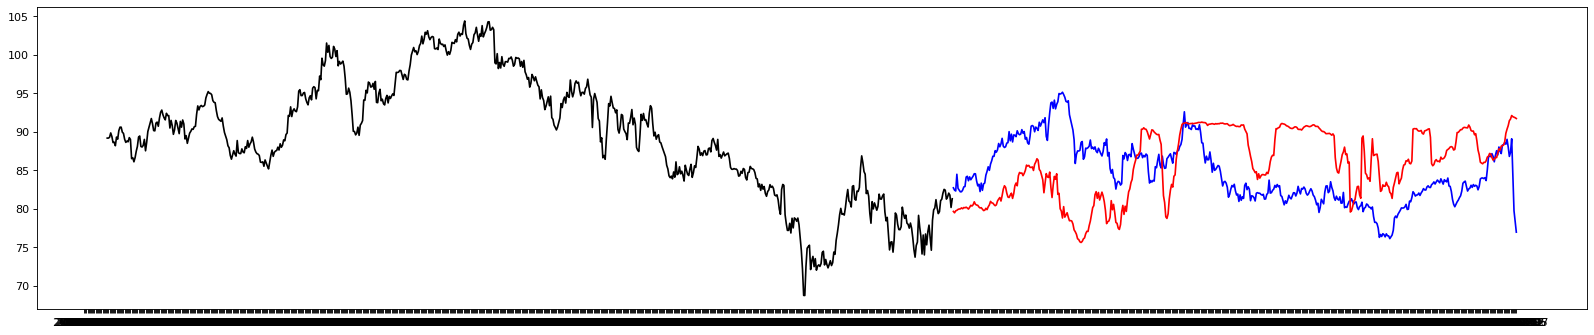

In [40]:
plotting(stock_train, stock_test)

In [ ]:
## Comments: in the figure above, the black line is the price of XOM used as the training set, the blue part is 
## the actual price during the testing timerange, and the red part is the predicted price in the tested timerange.

## The result above clearly shows that solely using the prices of commodities to predict the price of XOM is 
## impossible, since both are affected by many other factors. However, at some time, the network gives a roughly 
## acceptable prediction for the trend.

In [41]:
## Third approach: Hidden Markov Model
## This model takes the previous prices of XOM and Crude oil as the observation, and the hidden states are the 
## probable market trend of XOM and Crude Oil: 
## {(XOM up, Crude up), (XOM up, Crude not change), (XOM up, Crude down),
## (XOM not change, Crude up), (XOM not change, Crude not change), (XOM not change, Crude down),
## (XOM down, Crude up), (XOM down, Crude not change), (XOM down, Crude down)}

## Using the previous observations to estimate the transition probabilities from one state to another, and 
## estimate the most probable fractional change.

In [42]:
from pandas_datareader import data
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools
import timedelta

In [43]:
## Preparation
XOM_HMM = total[['Date', 'XOM_Open', 'XOM_Close', 'XOM_High', 'XOM_Low']]
CRUDE_HMM = total[['Date', 'CRUDE_Open', 'CRUDE_Close', 'CRUDE_High', 'CRUDE_Low']]
XOM_HMM = XOM_HMM.rename(columns={'Date' : 'Date', 'XOM_Open' : 'Open', 'XOM_High' : 'High', 'XOM_Low' : 'Low', 'XOM_Close' : 'Close'})
CRUDE_HMM = CRUDE_HMM.rename(columns={'Date' : 'Date', 'CRUDE_Open' : 'Open', 'CRUDE_High' : 'High', 'CRUDE_Low' : 'Low', 'CRUDE_Close' : 'Close'})

In [48]:
## Define the HMM prediciton model
class Predictor:
    def __init__(self, stock, commodity, start, end, hidden_states, latency, frac_change, frac_high, frac_low):
        self.stock = stock
        self.commodity = commodity
        self.start_date = start
        self.end_date = end
        self.hidden = hidden_states
        self.latency = latency
        self.hmm = GaussianHMM(n_components=hidden_states)
        self.all_possibles(frac_change, frac_high, frac_low)
        self.stock_train, self.stock_test = train_test_split(self.stock, shuffle=False)
        self.commodity_train, self.commodity_test = train_test_split(self.commodity, shuffle=False)
        self.days = len(self.stock_test)
    
    
    def feature(self, data):
        opener = np.array(data['Open'])
        closer = np.array(data['Close'])
        higher = np.array(data['High'])
        lowwer = np.array(data['Low'])
        
        frac_change = (closer - opener) / opener
        frac_high = (higher - opener) / opener
        frac_low = (lowwer - opener) / opener
        
        return np.column_stack((frac_change, frac_high, frac_low))
    
    
    def fit(self):
        stock_observation = self.feature(self.stock_train)
        commodity_observation = self.feature(self.commodity_train)
        observations = np.concatenate([stock_observation, commodity_observation])
        lengths = [len(stock_observation), len(commodity_observation)]
        self.hmm.fit(observations, lengths)
        
    
    def all_possibles(self, frac_allday, frac_high, frac_low):
        ## prediction accuracy: +- 0.2%
        allday_range = np.linspace(-frac_allday / 2, frac_allday / 2, int(frac_allday * 200))
        upside_range = np.linspace(0, frac_high, int(frac_high * 200))
        down_range = np.linspace(-frac_low, 0, int(frac_low * 200))
        self.possibilities = np.array(list(itertools.product(allday_range, upside_range, down_range)))
    
    
    def most_probab(self, day):
        prev_stock = self.stock_test.iloc[max(0, day - self.latency) : max(0, day - 1)]
        prev_commo = self.commodity_test.iloc[max(0, day - self.latency) : max(0, day - 1)]
        stock_obs = self.feature(prev_stock)
        commo_obs = self.feature(prev_commo)
        
        outcomes = []
        
        for possibility in self.possibilities:
            total = np.row_stack((stock_obs, commo_obs, possibility))
            outcomes.append(self.hmm.score(total))
        
        return self.possibilities[np.argmax(outcomes)]

    
    def predict_close(self, day):
        opener = self.stock_test.iloc[day]['Open']
        (frac_change, frac_high, frac_low) = self.most_probab(day)
        return opener * (1 + frac_change)
    
    
    def predict_closes(self):
        predictions = []
        for day in range(self.days):
            predictions.append(self.predict_close(day))
        return predictions
    
    
    def real_closes(self):
        actual = self.stock_test.loc[:, 'Close']
        return actual


In [49]:
def mse(df):
    actual = (df.loc[:, 'Actual']).values
    predic = (df.loc[:, 'Predicts']).values
    return mean_squared_error(actual, predic)

In [50]:
def plot(df):
    df = df.reset_index()
    ax = plt.gca()
    df.plot(kind="line", x="Date", y="Actual", ax=ax)
    df.plot(kind="line", x="Date", y="Predicts", color="red", ax=ax)
    plt.ylabel("Daily Close Price")
    plt.title("XOM daily closing stock prices")
    plt.show()

In [51]:
predictor = Predictor(stock=XOM_HMM, commodity=CRUDE_HMM, start=min(XOM_HMM['Date']), end=max(XOM_HMM['Date']), hidden_states=9, latency=10, frac_change=0.2, frac_high=0.1, frac_low=0.1)

## since it is reasonably to believe that the price of neither XOM nor Crude oil is able to 
## move up (or down) more than 10%, frac_change, frac_high, and frac_low are set so to decrease the 
## size of the transition probability matrix to speed up.

In [52]:
predictor.fit()

In [53]:
predicts = predictor.predict_closes()

In [62]:
## Combine Actual and Predicted results, print loss, plot price curve

actual = predictor.real_closes().reset_index()
dates = predictor.stock_test['Date'].reset_index()
combined = pd.DataFrame()
combined['Date'] = dates['Date']
combined['Actual'] = actual['Close']
combined['Predicts'] = predicts
print(mse(combined))

0.5774455481027216


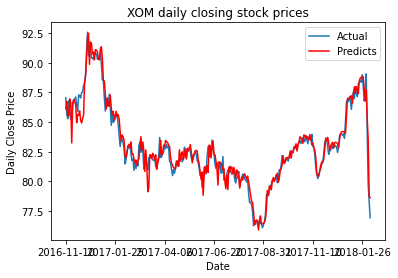

In [63]:
plot(combined)

In [ ]:
## Comments: as the above result presents, the HMM model has a relatively better performance compared with the 
## LSTM model which solely took the prices of commodities as the input. 

## Given the previous observations of XOM and Crude Oil, and the Open price of XOM on a given day, this model 
## is able to predict a fairly accurate closing price.